Setup

In [ ]:
import pandas as pd
import numpy as np
import string
import seaborn as sns
!pip install -U scikit-multiflow
#resource for profanity: https://pypi.org/project/profanity-check/
!pip install alt-profanity-check
!pip install sklearn --upgrade
#resource for sentiment: https://realpython.com/python-nltk-sentiment-analysis/#using-nltks-pre-trained-sentiment-analyzer
!pip install nltk
from profanity_check import predict
import nltk
nltk.download([
"names",
"stopwords",
"state_union",
"twitter_samples",
"movie_reviews",
"averaged_perceptron_tagger",
"vader_lexicon",
"punkt"])
from nltk.sentiment import SentimentIntensityAnalyzer
%matplotlib notebook
from google.colab import drive
drive.mount('/content/drive')

Dataset Fixing and Modifying

In [ ]:
#had to edit first row of csv file so that file was read with 3 columns and not 1
tweets = pd.read_csv("/content/drive/MyDrive/Master's Project/hatespeech_text_label_vote_RESTRICTED_100K_v2.csv")
tweets

,Tweet text Label Votes for the majority label,Unnamed: 1,Unnamed: 2
0,Beats by Dr. Dre urBeats Wired In-Ear Headphon...,spam,4
1,RT @Papapishu: Man it would fucking rule if we...,abusive,4
2,It is time to draw close to Him &#128591;&#127...,normal,4
3,if you notice me start to act different or dis...,normal,5
4,"Forget unfollowers, I believe in growing. 7 ne...",normal,3
...,...,...,...
99991,RT @shangros: my fucking queen https://t.co/wa...,abusive,5
99992,#Osteporosis treated with #PEMF - rebuild bone...,normal,3
99993,@LGUSAMobile why does my phone screen keeps fl...,normal,3
99994,#bigdata vs. #reality ... but equally applies ...,normal,5


In [ ]:
#had to fix dataframe column names
tweets = tweets.rename(columns={"Tweet text  Label   Votes for the majority label": "Tweet text", "Unnamed: 1": "Label", "Unnamed: 2": "Votes for the majority label"})
#last column not needed
tweets.drop(tweets.columns[[2]], axis=1, inplace=True)
tweets

Abusive/Hateful Tweets

In [ ]:
#"spam" labels not needed
tweets = tweets[tweets['Label'] != "spam"]
tweets

,Tweet text,Label
1,RT @Papapishu: Man it would fucking rule if we...,abusive
2,It is time to draw close to Him &#128591;&#127...,normal
3,if you notice me start to act different or dis...,normal
4,"Forget unfollowers, I believe in growing. 7 ne...",normal
5,RT @Vitiligoprince: Hate Being sexually Frustr...,abusive
...,...,...
99991,RT @shangros: my fucking queen https://t.co/wa...,abusive
99992,#Osteporosis treated with #PEMF - rebuild bone...,normal
99993,@LGUSAMobile why does my phone screen keeps fl...,normal
99994,#bigdata vs. #reality ... but equally applies ...,normal


In [ ]:
#check to make sure spam labels dropped
pd.unique(tweets['Label'])

Tweet Feature Extraction And Data Cleaning/Processing

In [ ]:
tweets["@ count"] = tweets['Tweet text'].str.count('@')
#Remove @'s from tweet text
tweets['Tweet text'] = tweets['Tweet text'].str.replace('@[\S]*', '')

tweets['Hashtag count'] = tweets['Tweet text'].str.count('#')
#Remove #'s from tweet text
tweets['Tweet text'] = tweets['Tweet text'].str.replace('#[\S]*','')

tweets['Retweet'] = tweets['Tweet text'].str.contains('RT')
#Remove RT's from tweet text
tweets['Tweet text'] = tweets['Tweet text'].str.replace('RT', '')

tweets['Url count'] = tweets['Tweet text'].str.count('http[\S]*')
#Remove URL's from tweet text
tweets['Tweet text'] = tweets['Tweet text'].str.replace('http[\S]*','')

tweets['Uppercase word count'] = tweets['Tweet text'].apply(lambda x: sum(map(str.isupper, x.split())))

tweets['Num sentences'] = tweets['Tweet text'].apply(lambda x: len(nltk.sent_tokenize(x)))

tweets['temp'] = tweets['Tweet text'].apply(lambda x: nltk.sent_tokenize(x))
tweets['Avg sentence len'] = tweets['temp'].apply(lambda x: pd.Series(x).apply(lambda y: len(nltk.word_tokenize(y))).mean())
tweets.drop(tweets.columns[[8]], axis=1, inplace=True)

#Got rid of tweets with no text information after data cleaning/processing
tweets['Text empty'] = tweets['Tweet text'].apply(lambda x: x.isspace())
tweets = tweets[tweets['Text empty'] != True]
tweets.drop(tweets.columns[[9]], axis=1, inplace=True)
tweets['Text empty'] = tweets['Tweet text'].apply(lambda x: len(x) == 0)
tweets = tweets[tweets['Text empty'] != True]
tweets.drop(tweets.columns[[9]], axis=1, inplace=True)

<ipython-input-10-c2e6dfa1edf4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets["@ count"] = tweets['Tweet text'].str.count('@')
<ipython-input-10-c2e6dfa1edf4>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  tweets['Tweet text'] = tweets['Tweet text'].str.replace('@[\S]*', '')
<ipython-input-10-c2e6dfa1edf4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets['Tweet text'] = tweets['Tweet text'].str.replace('@[\S]*', '')
<ipython-input-10-c2e6d

In [ ]:
sia = SentimentIntensityAnalyzer() #Sentiment is 'compound' value from -1 to 1
tweets['Sentiment'] = tweets['Tweet text'].apply(lambda x: sia.polarity_scores(x)['compound'])

#Create temperorary parts of speech column
from collections import Counter
tweets['temp'] = tweets['Tweet text'].apply(lambda x: nltk.pos_tag(x.split()))
tweets['temp'] = tweets['temp'].apply(lambda x: Counter(tag for word,tag in x))

#Counting all adjectives
tweets['Adjective count'] = tweets['temp'].apply(lambda x: x['JJ'])
tweets['Adjective count'] = tweets['Adjective count'] + tweets['temp'].apply(lambda x: x['JJR'])
tweets['Adjective count'] = tweets['Adjective count'] + tweets['temp'].apply(lambda x: x['JJS'])

#Counting all verbs
tweets['Verb count'] = tweets['temp'].apply(lambda x: x['VB'])
tweets['Verb count'] = tweets['Verb count'] + tweets['temp'].apply(lambda x: x['VBP'])
tweets['Verb count'] = tweets['Verb count'] + tweets['temp'].apply(lambda x: x['VBD'])
tweets['Verb count'] = tweets['Verb count'] + tweets['temp'].apply(lambda x: x['VBG'])
tweets['Verb count'] = tweets['Verb count'] + tweets['temp'].apply(lambda x: x['VBN'])
tweets['Verb count'] = tweets['Verb count'] + tweets['temp'].apply(lambda x: x['VBZ'])

#Counting all adverbs
tweets['Adverb count'] = tweets['temp'].apply(lambda x: x['RB'])
tweets['Adverb count'] = tweets['Adverb count'] + tweets['temp'].apply(lambda x: x['RBR'])
tweets['Adverb count'] = tweets['Adverb count'] + tweets['temp'].apply(lambda x: x['RBS'])

#Remove temperoary parts of speech column
tweets.drop(tweets.columns[[10]], axis=1, inplace=True)

#Remove punctuation from tweet text
tweets['Tweet text'] = tweets['Tweet text'].str.replace('[^\w\s]', '')
#Remove numbers from tweet text
tweets['Tweet text'] = tweets['Tweet text'].str.replace('\d', '')
#Remove non-letters from tweet text
tweets['Tweet text'] = tweets['Tweet text'].str.replace('[^a-zA-Z]', ' ')

#Got rid of tweets with no text information after data cleaning/processing
tweets['Text empty'] = tweets['Tweet text'].apply(lambda x: x.isspace())
tweets = tweets[tweets['Text empty'] != True]
tweets.drop(tweets.columns[[13]], axis=1, inplace=True)
tweets['Text empty'] = tweets['Tweet text'].apply(lambda x: len(x) == 0)
tweets = tweets[tweets['Text empty'] != True]
tweets.drop(tweets.columns[[13]], axis=1, inplace=True)

tweets['Profanity count'] = tweets['Tweet text'].str.replace('\W', ' ').str.split()
tweets['Profanity count'] = tweets['Profanity count'].apply(lambda x: sum(predict(x)))

tweets['Avg word len'] = tweets['Tweet text'].apply(lambda x: sum(list(map(len,x.split()))) / len(x.split()))

<ipython-input-11-5cfc110e5f75>:31: FutureWarning: The default value of regex will change from True to False in a future version.
  tweets['Tweet text'] = tweets['Tweet text'].str.replace('[^\w\s]', '')
<ipython-input-11-5cfc110e5f75>:33: FutureWarning: The default value of regex will change from True to False in a future version.
  tweets['Tweet text'] = tweets['Tweet text'].str.replace('\d', '')
<ipython-input-11-5cfc110e5f75>:35: FutureWarning: The default value of regex will change from True to False in a future version.
  tweets['Tweet text'] = tweets['Tweet text'].str.replace('[^a-zA-Z]', ' ')
<ipython-input-11-5cfc110e5f75>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets.drop(tweets.columns[[13]], axis=1, inplace=True)
<ipython-input-11-5cfc110e5f75>:41: SettingWithCopyWarning: 
A value

In [ ]:
tweets_copy = tweets.copy()
tweets

,Tweet text,Label,@ count,Hashtag count,Retweet,Url count,Uppercase word count,Num sentences,Avg sentence len,Sentiment,Adjective count,Verb count,Adverb count,Profanity count,Avg word len
1,Man it would fucking rule if we had a party ...,abusive,1,0,True,0,0,1,16.0,0.1280,1,3,0,1,4.266667
2,It is time to draw close to Him Father I draw...,normal,0,2,False,1,1,1,20.0,0.0000,0,4,3,0,3.294118
3,if you notice me start to act different or dis...,normal,0,0,False,0,0,1,35.0,0.0000,5,8,0,0,3.633333
4,Forget unfollowers I believe in growing new f...,normal,0,0,False,1,1,3,6.0,-0.1260,3,1,0,0,4.714286
5,Hate Being sexually Frustrated Like I wanna ...,abusive,1,0,True,0,1,1,16.0,-0.8689,0,2,1,3,4.785714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99991,my fucking queen,abusive,1,0,True,1,0,1,3.0,0.0000,0,0,0,1,4.666667
99992,treated with rebuild bone mass,normal,0,3,False,2,0,1,7.0,0.0000,0,1,0,0,5.200000
99993,why does my phone screen keeps flickring im s...,normal,1,4,False,0,0,1,29.0,-0.9430,4,4,2,1,3.576923
99994,vs but equally applies to any project,normal,0,3,False,2,0,1,8.0,0.0000,0,0,1,0,4.428571


A/H Basic Tweet Analysis

In [ ]:
tweets['Label'].value_counts()

normal     53655
abusive    27141
hateful     4963
Name: Label, dtype: int64

In [ ]:
tweets['@ count'].value_counts()

0     42355
1     31725
2      6698
3      2572
4      1131
5       561
6       269
7       235
8       129
9        57
10       20
11        5
12        2
Name: @ count, dtype: int64

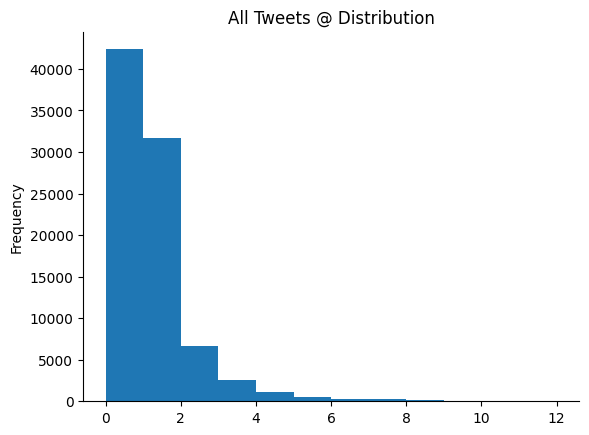

In [ ]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
tweets['@ count'].plot(kind='hist', bins=12, title='All Tweets @ Distribution')
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.show()

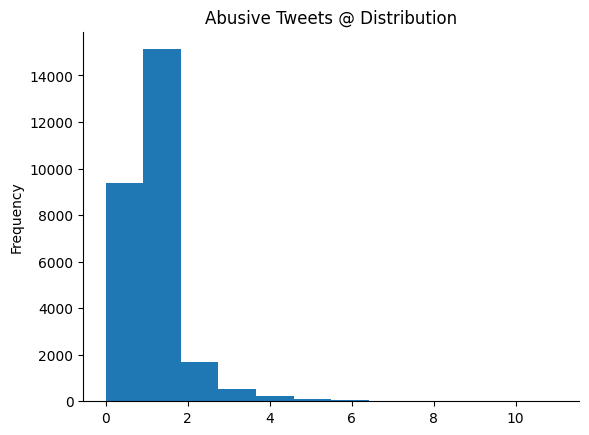

In [ ]:
tweets[tweets['Label'] == "abusive"]['@ count'].plot(kind='hist', bins=12, title='Abusive Tweets @ Distribution')
plt.gca().spines[['top', 'right',]].set_visible(False)

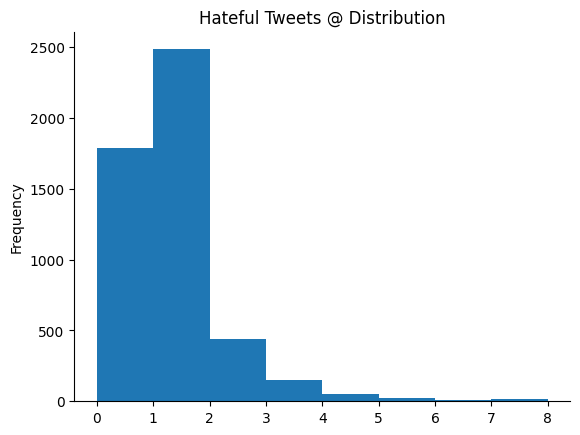

In [ ]:
tweets[tweets['Label'] == "hateful"]['@ count'].plot(kind='hist', bins=8, title='Hateful Tweets @ Distribution')
plt.gca().spines[['top', 'right',]].set_visible(False)

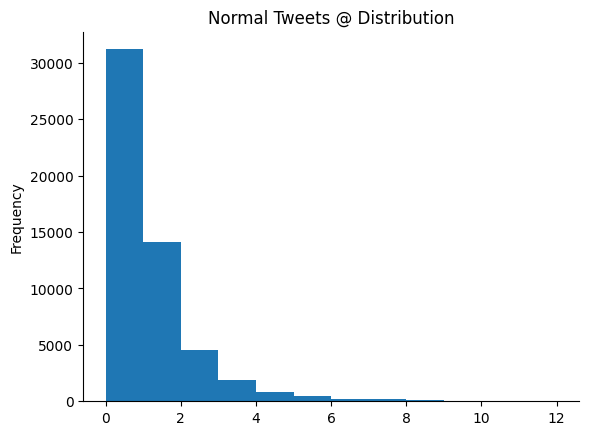

In [ ]:
tweets[tweets['Label'] == "normal"]['@ count'].plot(kind='hist', bins=12, title='Normal Tweets @ Distribution')
plt.gca().spines[['top', 'right',]].set_visible(False)

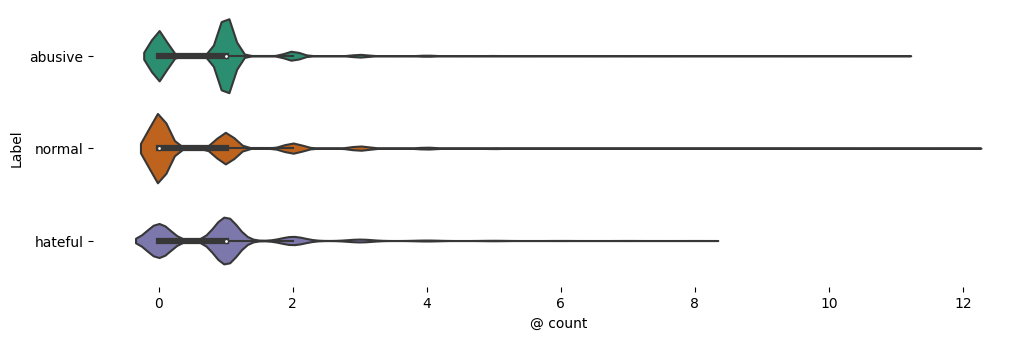

In [ ]:
figsize = (12, 1.2 * len(tweets['Label'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(tweets, x='@ count', y='Label', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:
tweets['Hashtag count'].value_counts()

0      60615
1      12436
2       6072
3       3217
4       1948
5        555
6        289
7        181
8        139
9         65
11        43
10        39
12        29
13        19
27        18
14        13
15        12
24        10
16        10
17         7
18         7
21         4
22         4
19         3
30         3
34         2
33         2
25         2
20         2
35         1
23         1
29         1
54         1
60         1
103        1
59         1
64         1
97         1
28         1
78         1
36         1
31         1
Name: Hashtag count, dtype: int64

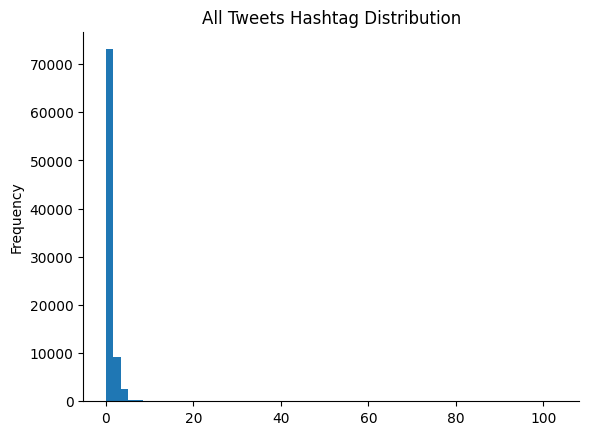

In [ ]:
tweets['Hashtag count'].plot(kind='hist', bins=60, title='All Tweets Hashtag Distribution')
plt.gca().spines[['top', 'right',]].set_visible(False)

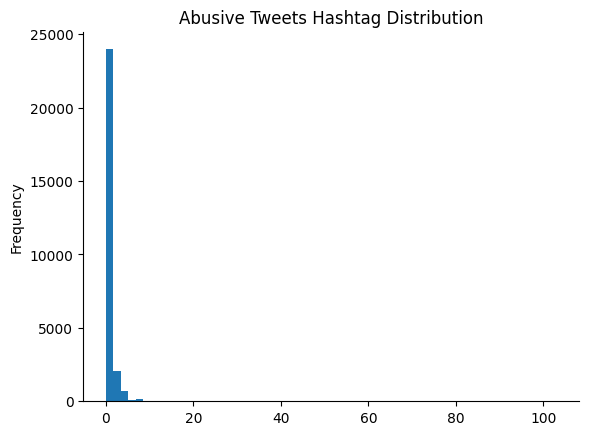

In [ ]:
tweets[tweets['Label'] == "abusive"]['Hashtag count'].plot(kind='hist', bins=60, title='Abusive Tweets Hashtag Distribution')
plt.gca().spines[['top', 'right',]].set_visible(False)

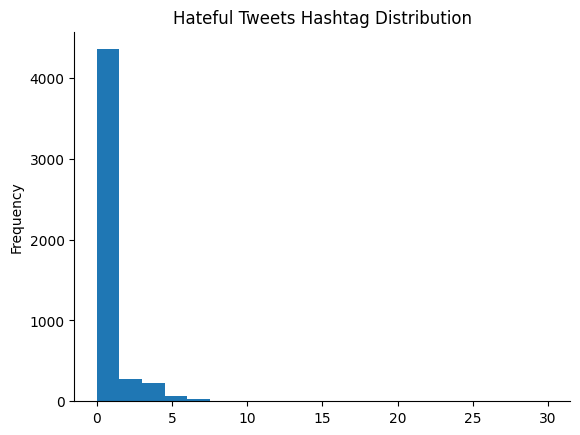

In [ ]:
tweets[tweets['Label'] == "hateful"]['Hashtag count'].plot(kind='hist', bins=20, title='Hateful Tweets Hashtag Distribution')
plt.gca().spines[['top', 'right',]].set_visible(False)

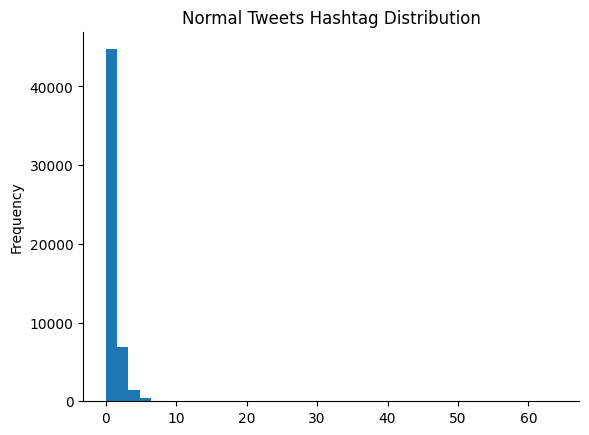

In [ ]:
tweets[tweets['Label'] == "normal"]['Hashtag count'].plot(kind='hist', bins=40, title='Normal Tweets Hashtag Distribution')
plt.gca().spines[['top', 'right',]].set_visible(False)

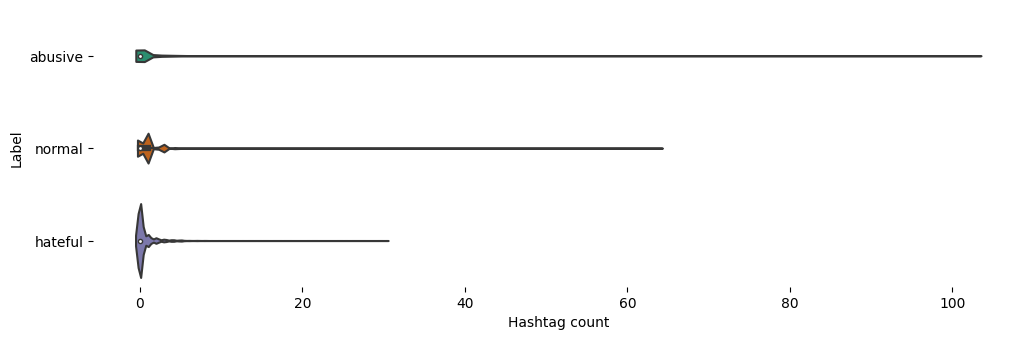

In [ ]:
figsize = (12, 1.2 * len(tweets['Label'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(tweets, x='Hashtag count', y='Label', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:
tweets['Retweet'].value_counts()

False    68644
True     17115
Name: Retweet, dtype: int64

In [ ]:
#Normal Tweets Retweet Distribution
tweets[tweets['Label'] == "normal"]['Retweet'].value_counts()

False    51921
True      1734
Name: Retweet, dtype: int64

In [ ]:
#Abusive Tweets Retweet Distribution
tweets[tweets['Label'] == "abusive"]['Retweet'].value_counts()

True     13574
False    13567
Name: Retweet, dtype: int64

In [ ]:
#Hateful Tweets Retweet Distribution
tweets[tweets['Label'] == "hateful"]['Retweet'].value_counts()

False    3156
True     1807
Name: Retweet, dtype: int64

In [ ]:
tweets['Uppercase word count'].value_counts()

0     51803
1     19323
2      6687
3      2623
4      1242
5       796
6       480
7       454
8       300
9       286
10      236
12      230
11      191
13      172
14      111
17      107
15      105
19       93
22       92
16       90
18       82
20       56
21       52
23       43
24       35
25       27
26       17
28        8
29        7
27        6
30        3
31        2
Name: Uppercase word count, dtype: int64

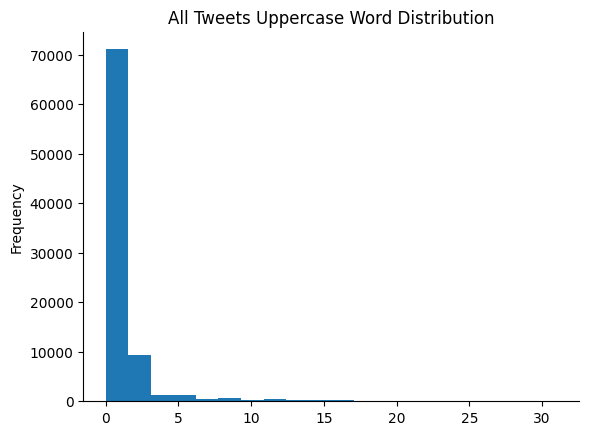

In [ ]:
tweets['Uppercase word count'].plot(kind='hist', bins=20, title='All Tweets Uppercase Word Distribution')
plt.gca().spines[['top', 'right',]].set_visible(False)

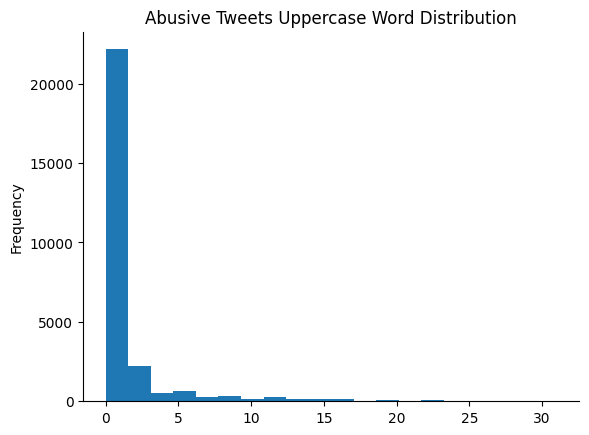

In [ ]:
tweets[tweets['Label'] == "abusive"]['Uppercase word count'].plot(kind='hist', bins=20, title='Abusive Tweets Uppercase Word Distribution')
plt.gca().spines[['top', 'right',]].set_visible(False)

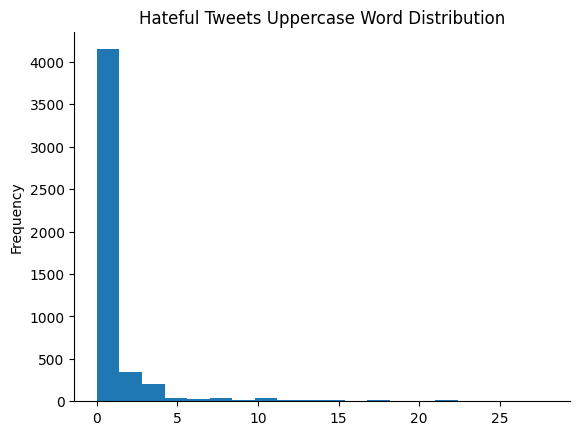

In [ ]:
tweets[tweets['Label'] == "hateful"]['Uppercase word count'].plot(kind='hist', bins=20, title='Hateful Tweets Uppercase Word Distribution')
plt.gca().spines[['top', 'right',]].set_visible(False)

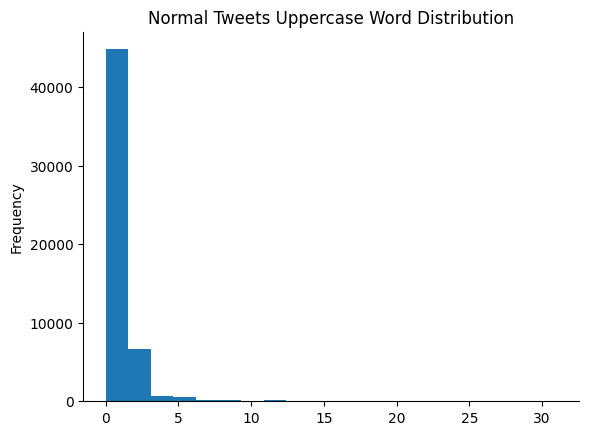

In [ ]:
tweets[tweets['Label'] == "normal"]['Uppercase word count'].plot(kind='hist', bins=20, title='Normal Tweets Uppercase Word Distribution')
plt.gca().spines[['top', 'right',]].set_visible(False)

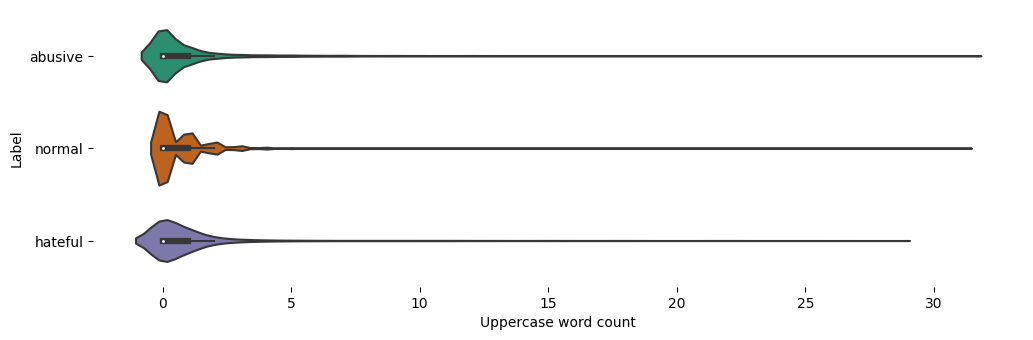

In [ ]:
figsize = (12, 1.2 * len(tweets['Label'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(tweets, x='Uppercase word count', y='Label', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:
tweets['Profanity count'].value_counts()

0     47936
1     23331
2      9943
3      3298
4       881
5       256
6        58
7        23
9        12
8        11
10        5
11        3
16        1
13        1
Name: Profanity count, dtype: int64

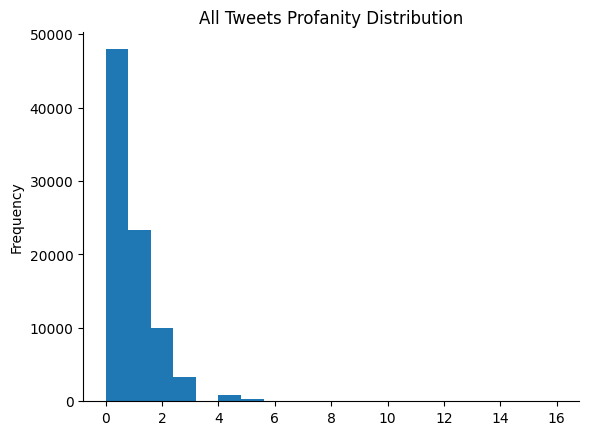

In [ ]:
tweets['Profanity count'].plot(kind='hist', bins=20, title='All Tweets Profanity Distribution')
plt.gca().spines[['top', 'right',]].set_visible(False)

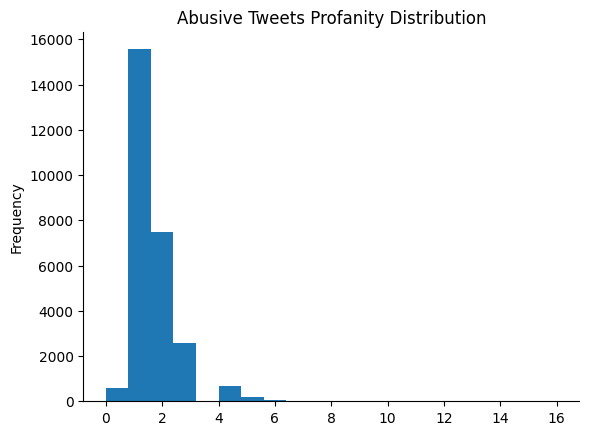

In [ ]:
tweets[tweets['Label'] == "abusive"]['Profanity count'].plot(kind='hist', bins=20, title='Abusive Tweets Profanity Distribution')
plt.gca().spines[['top', 'right',]].set_visible(False)

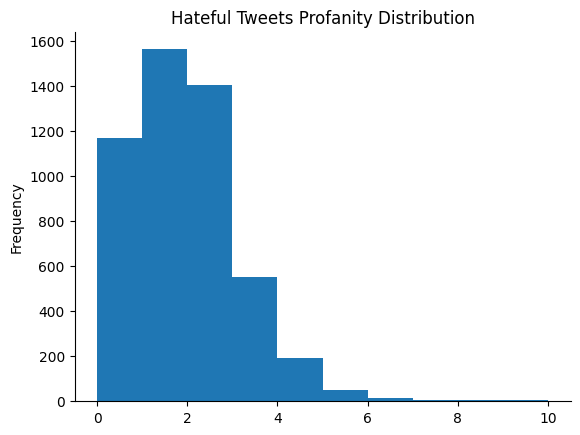

In [ ]:
tweets[tweets['Label'] == "hateful"]['Profanity count'].plot(kind='hist', bins=10, title='Hateful Tweets Profanity Distribution')
plt.gca().spines[['top', 'right',]].set_visible(False)

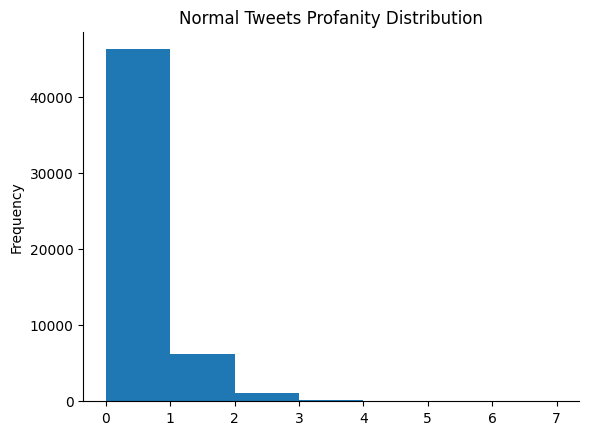

In [ ]:
tweets[tweets['Label'] == "normal"]['Profanity count'].plot(kind='hist', bins=7, title='Normal Tweets Profanity Distribution')
plt.gca().spines[['top', 'right',]].set_visible(False)

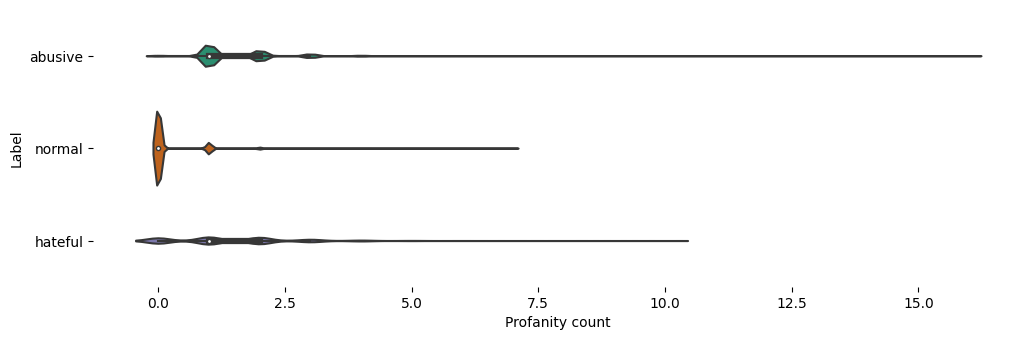

In [ ]:
figsize = (12, 1.2 * len(tweets['Label'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(tweets, x='Profanity count', y='Label', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

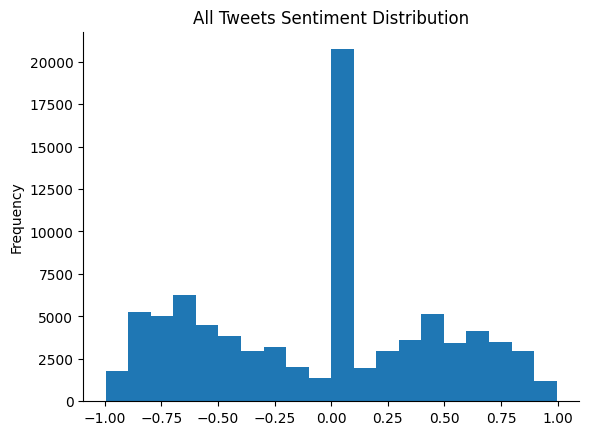

In [ ]:
tweets['Sentiment'].plot(kind='hist', bins=20, title='All Tweets Sentiment Distribution')
plt.gca().spines[['top', 'right',]].set_visible(False)

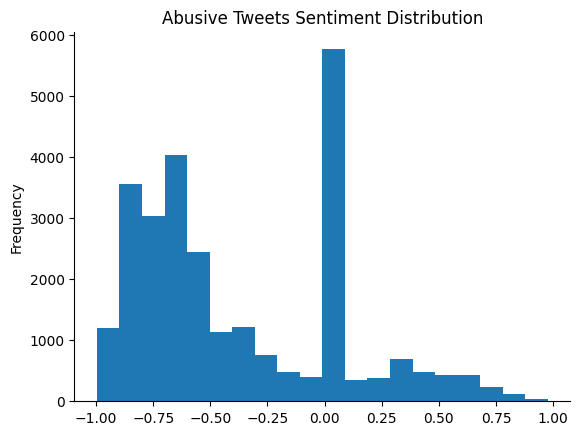

In [ ]:
tweets[tweets['Label'] == "abusive"]['Sentiment'].plot(kind='hist', bins=20, title='Abusive Tweets Sentiment Distribution')
plt.gca().spines[['top', 'right',]].set_visible(False)

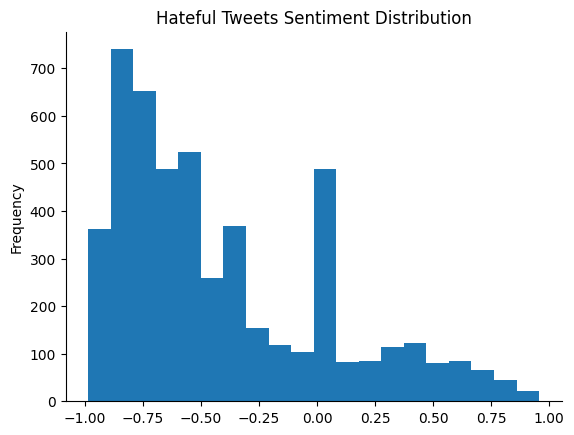

In [ ]:
tweets[tweets['Label'] == "hateful"]['Sentiment'].plot(kind='hist', bins=20, title='Hateful Tweets Sentiment Distribution')
plt.gca().spines[['top', 'right',]].set_visible(False)

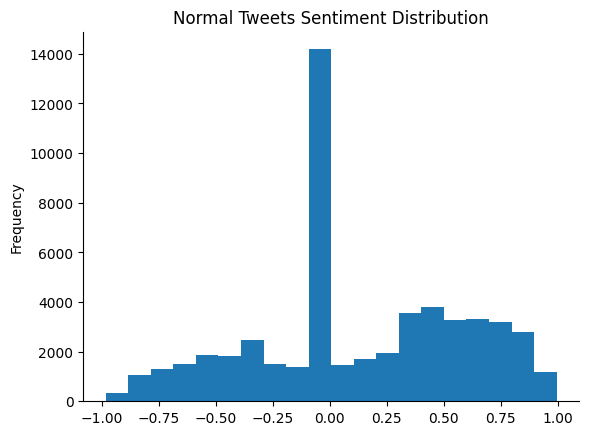

In [ ]:
tweets[tweets['Label'] == "normal"]['Sentiment'].plot(kind='hist', bins=20, title='Normal Tweets Sentiment Distribution')
plt.gca().spines[['top', 'right',]].set_visible(False)

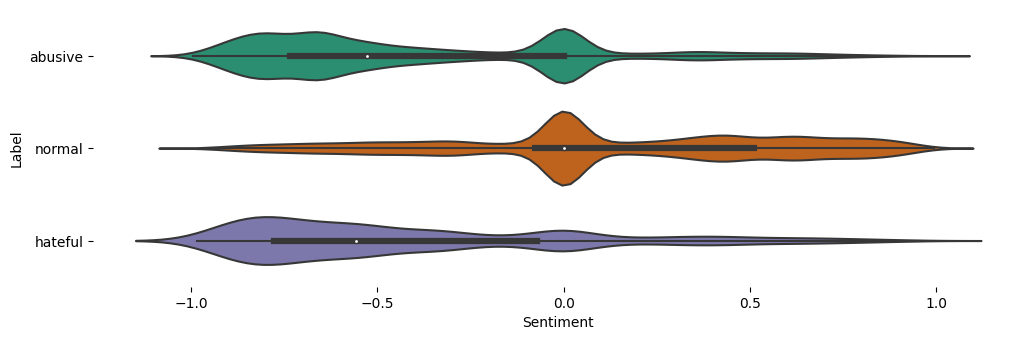

In [ ]:
figsize = (12, 1.2 * len(tweets['Label'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(tweets, x='Sentiment', y='Label', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

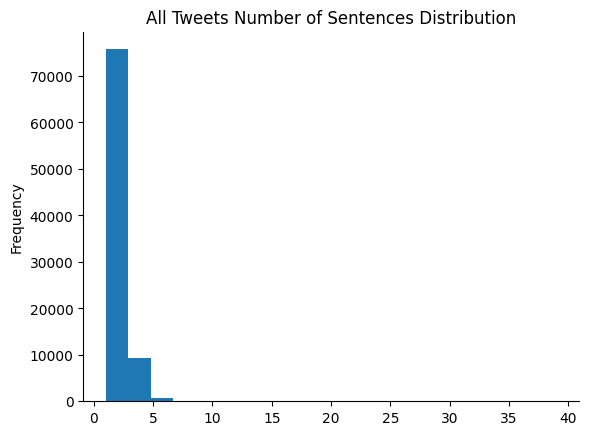

In [ ]:
tweets['Num sentences'].plot(kind='hist', bins=20, title='All Tweets Number of Sentences Distribution')
plt.gca().spines[['top', 'right',]].set_visible(False)

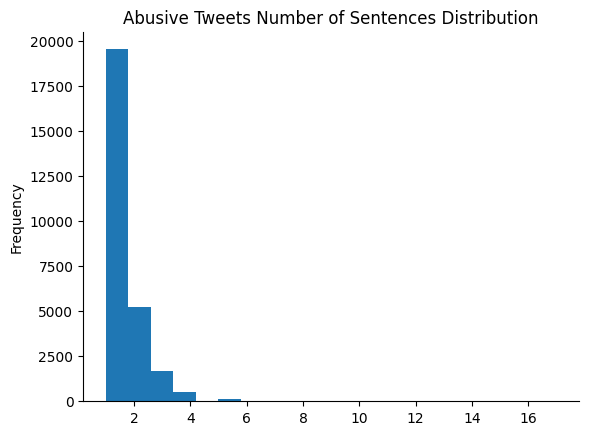

In [ ]:
tweets[tweets['Label'] == "abusive"]['Num sentences'].plot(kind='hist', bins=20, title='Abusive Tweets Number of Sentences Distribution')
plt.gca().spines[['top', 'right',]].set_visible(False)

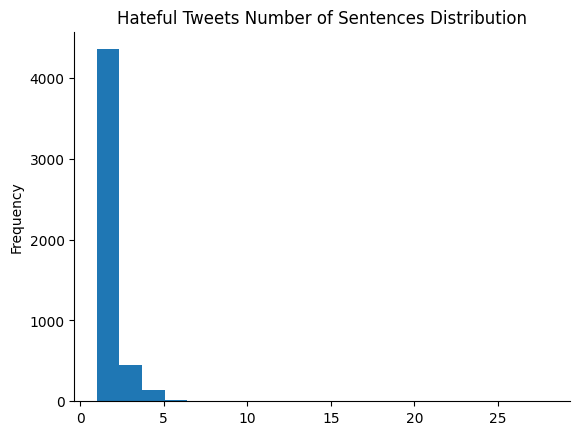

In [ ]:
tweets[tweets['Label'] == "hateful"]['Num sentences'].plot(kind='hist', bins=20, title='Hateful Tweets Number of Sentences Distribution')
plt.gca().spines[['top', 'right',]].set_visible(False)

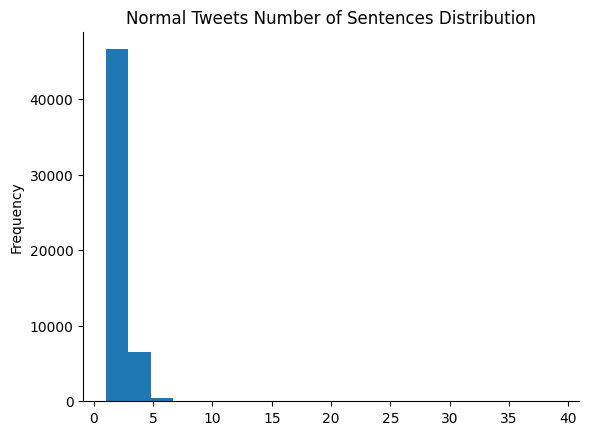

In [ ]:
tweets[tweets['Label'] == "normal"]['Num sentences'].plot(kind='hist', bins=20, title='Normal Tweets Number of Sentences Distribution')
plt.gca().spines[['top', 'right',]].set_visible(False)

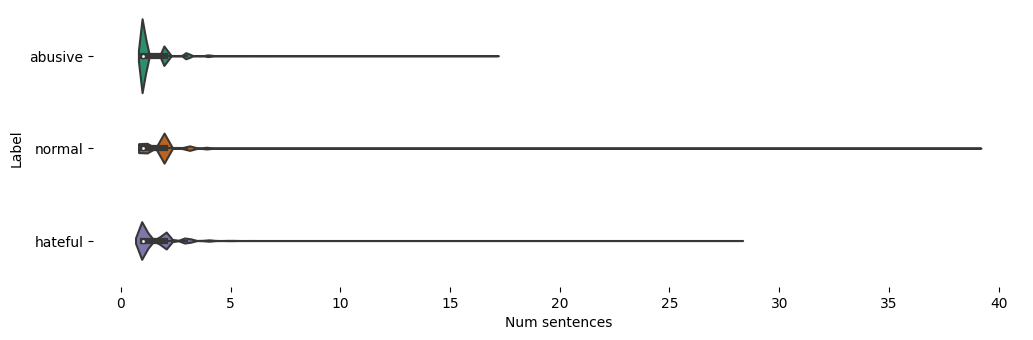

In [ ]:
figsize = (12, 1.2 * len(tweets['Label'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(tweets, x='Num sentences', y='Label', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

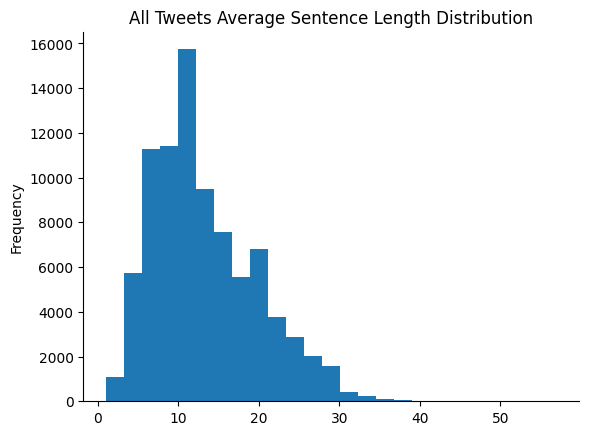

In [ ]:
tweets['Avg sentence len'].plot(kind='hist', bins=25, title='All Tweets Average Sentence Length Distribution')
plt.gca().spines[['top', 'right',]].set_visible(False)

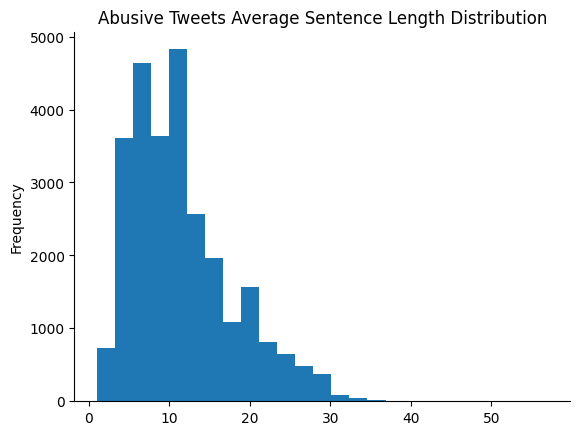

In [ ]:
tweets[tweets['Label'] == "abusive"]['Avg sentence len'].plot(kind='hist', bins=25, title='Abusive Tweets Average Sentence Length Distribution')
plt.gca().spines[['top', 'right',]].set_visible(False)

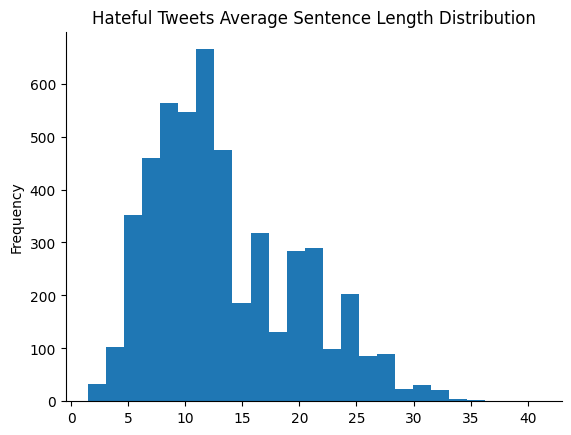

In [ ]:
tweets[tweets['Label'] == "hateful"]['Avg sentence len'].plot(kind='hist', bins=25, title='Hateful Tweets Average Sentence Length Distribution')
plt.gca().spines[['top', 'right',]].set_visible(False)

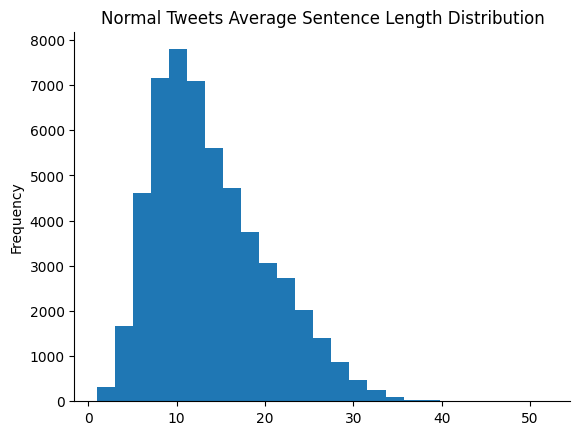

In [ ]:
tweets[tweets['Label'] == "normal"]['Avg sentence len'].plot(kind='hist', bins=25, title='Normal Tweets Average Sentence Length Distribution')
plt.gca().spines[['top', 'right',]].set_visible(False)

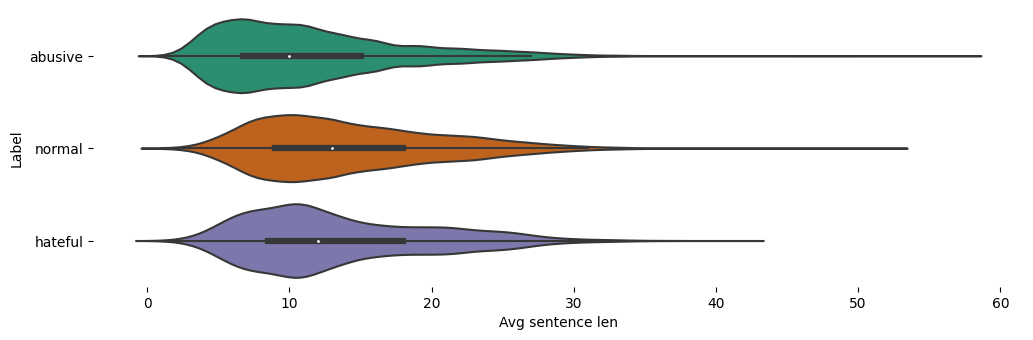

In [ ]:
figsize = (12, 1.2 * len(tweets['Label'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(tweets, x='Avg sentence len', y='Label', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

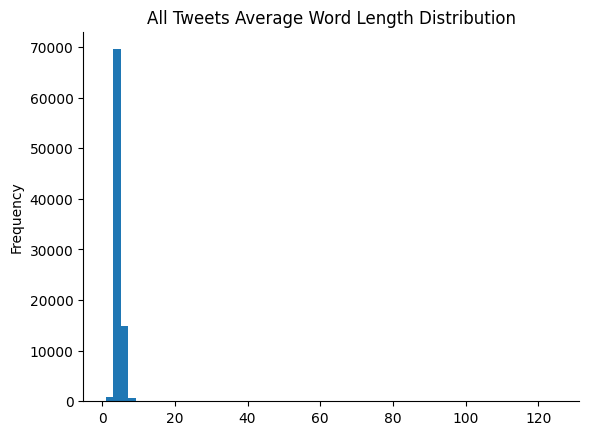

In [ ]:
tweets['Avg word len'].plot(kind='hist', bins=60, title='All Tweets Average Word Length Distribution')
plt.gca().spines[['top', 'right',]].set_visible(False)

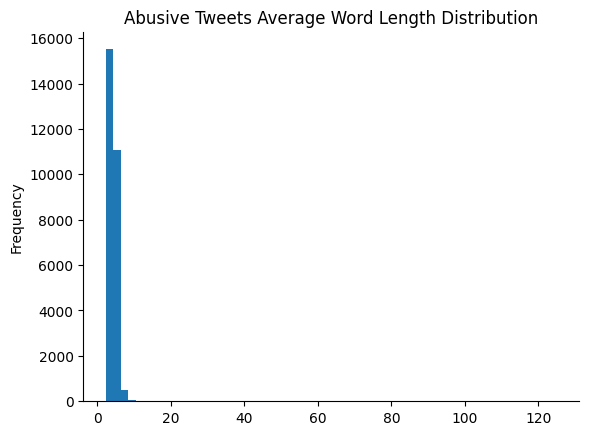

In [ ]:
tweets[tweets['Label'] == "abusive"]['Avg word len'].plot(kind='hist', bins=60, title='Abusive Tweets Average Word Length Distribution')
plt.gca().spines[['top', 'right',]].set_visible(False)

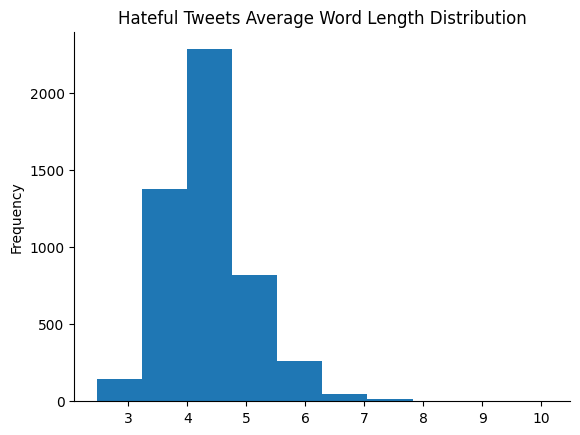

In [ ]:
tweets[tweets['Label'] == "hateful"]['Avg word len'].plot(kind='hist', bins=10, title='Hateful Tweets Average Word Length Distribution')
plt.gca().spines[['top', 'right',]].set_visible(False)

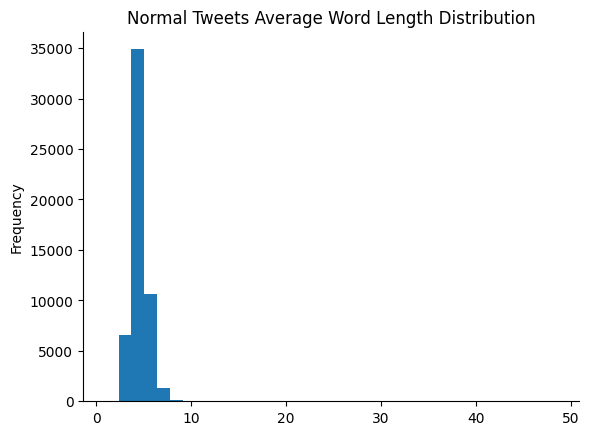

In [ ]:
tweets[tweets['Label'] == "normal"]['Avg word len'].plot(kind='hist', bins=35, title='Normal Tweets Average Word Length Distribution')
plt.gca().spines[['top', 'right',]].set_visible(False)

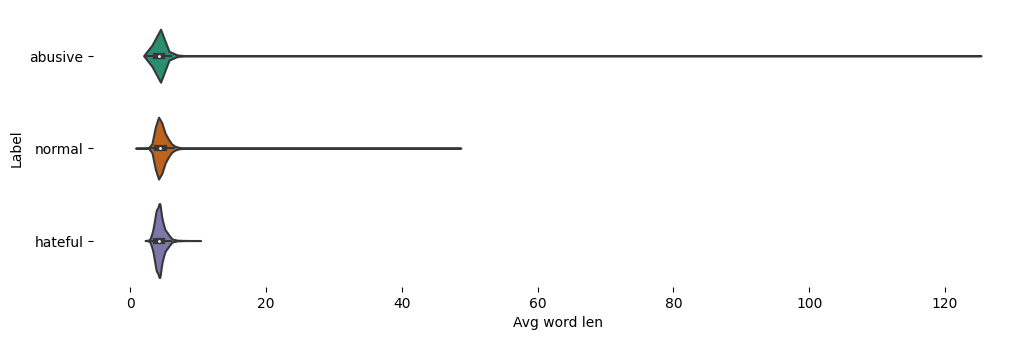

In [ ]:
figsize = (12, 1.2 * len(tweets['Label'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(tweets, x='Avg word len', y='Label', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

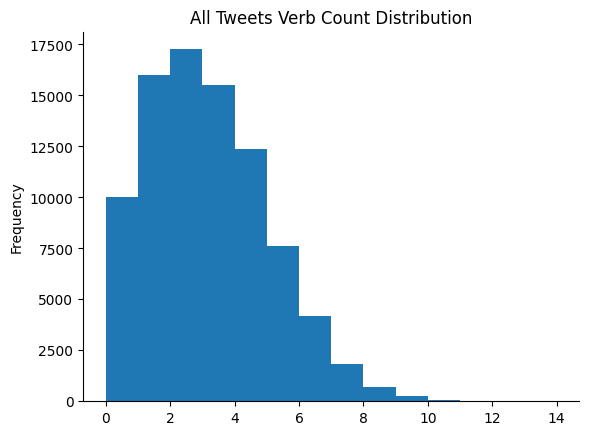

In [ ]:
tweets['Verb count'].plot(kind='hist', bins=14, title='All Tweets Verb Count Distribution')
plt.gca().spines[['top', 'right',]].set_visible(False)

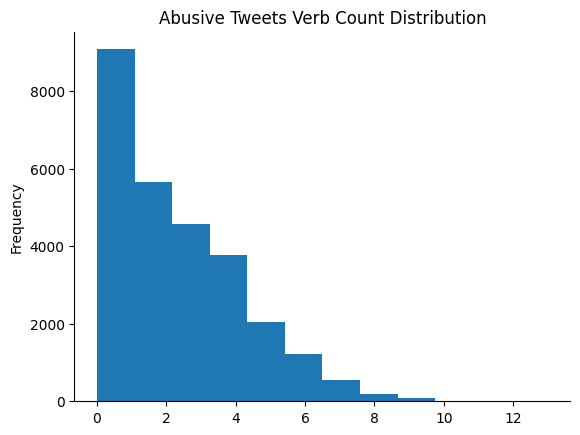

In [ ]:
tweets[tweets['Label'] == "abusive"]['Verb count'].plot(kind='hist', bins=12, title='Abusive Tweets Verb Count Distribution')
plt.gca().spines[['top', 'right',]].set_visible(False)

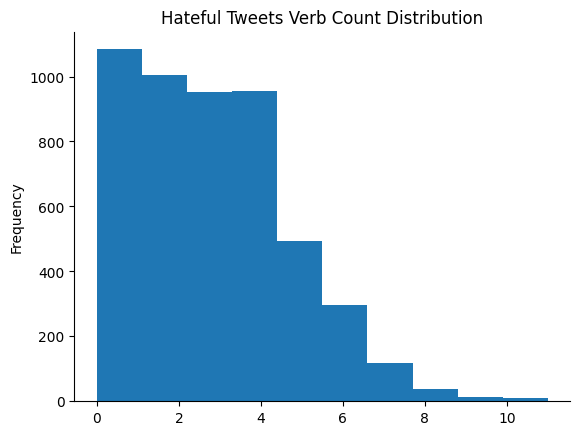

In [ ]:
tweets[tweets['Label'] == "hateful"]['Verb count'].plot(kind='hist', bins=10, title='Hateful Tweets Verb Count Distribution')
plt.gca().spines[['top', 'right',]].set_visible(False)

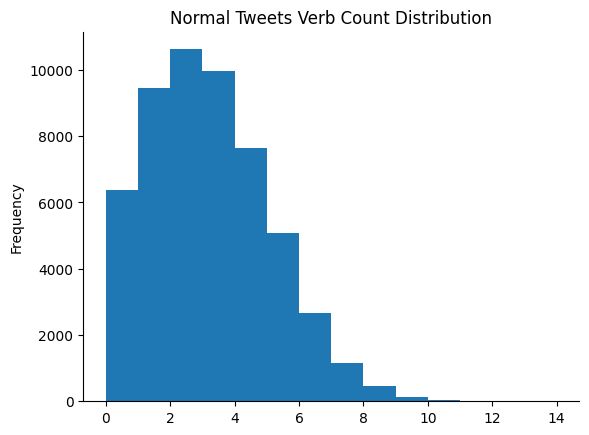

In [ ]:
tweets[tweets['Label'] == "normal"]['Verb count'].plot(kind='hist', bins=14, title='Normal Tweets Verb Count Distribution')
plt.gca().spines[['top', 'right',]].set_visible(False)

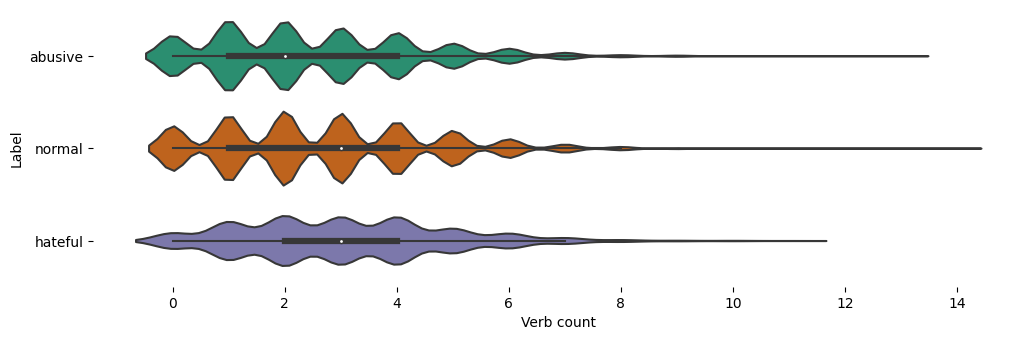

In [ ]:
figsize = (12, 1.2 * len(tweets['Label'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(tweets, x='Verb count', y='Label', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

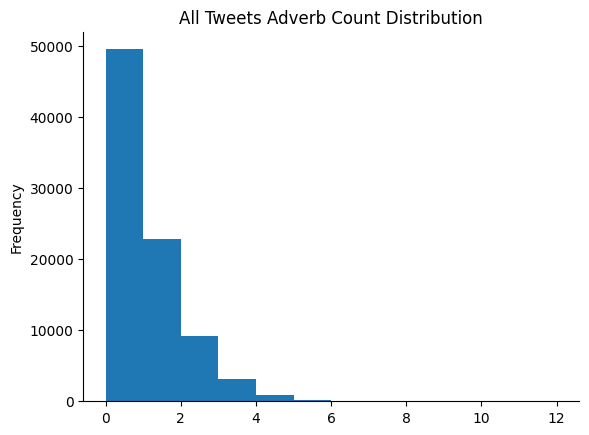

In [ ]:
tweets['Adverb count'].plot(kind='hist', bins=12, title='All Tweets Adverb Count Distribution')
plt.gca().spines[['top', 'right',]].set_visible(False)

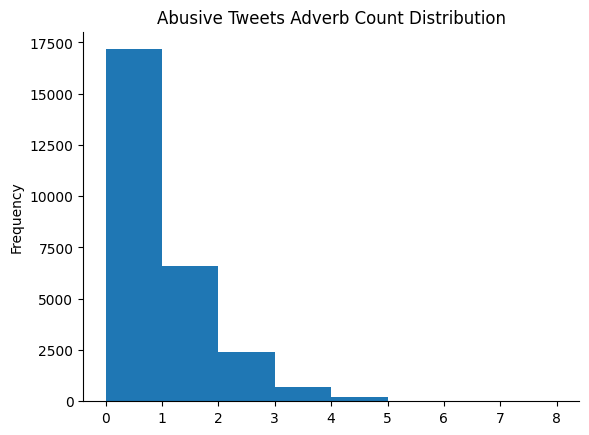

In [ ]:
tweets[tweets['Label'] == "abusive"]['Adverb count'].plot(kind='hist', bins=8, title='Abusive Tweets Adverb Count Distribution')
plt.gca().spines[['top', 'right',]].set_visible(False)

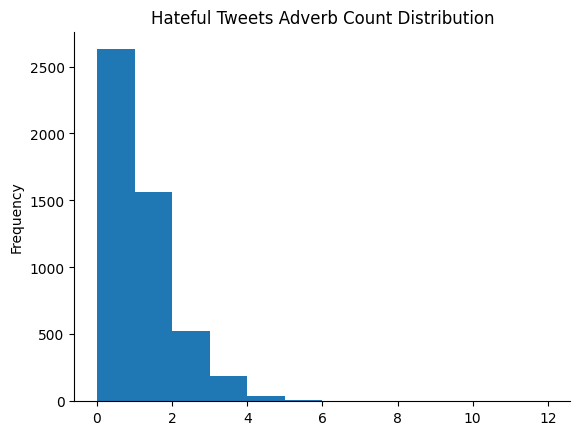

In [ ]:
tweets[tweets['Label'] == "hateful"]['Adverb count'].plot(kind='hist', bins=12, title='Hateful Tweets Adverb Count Distribution')
plt.gca().spines[['top', 'right',]].set_visible(False)

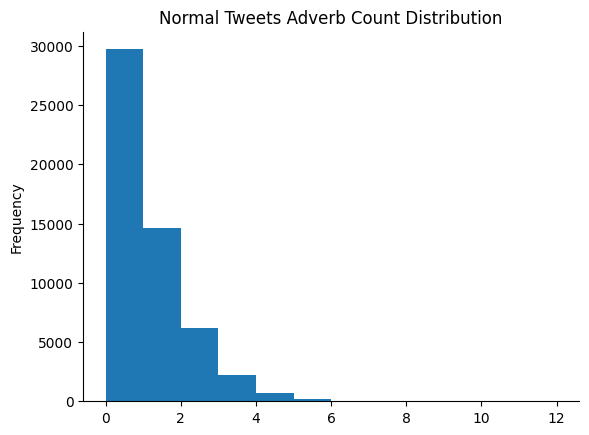

In [ ]:
tweets[tweets['Label'] == "normal"]['Adverb count'].plot(kind='hist', bins=12, title='Normal Tweets Adverb Count Distribution')
plt.gca().spines[['top', 'right',]].set_visible(False)

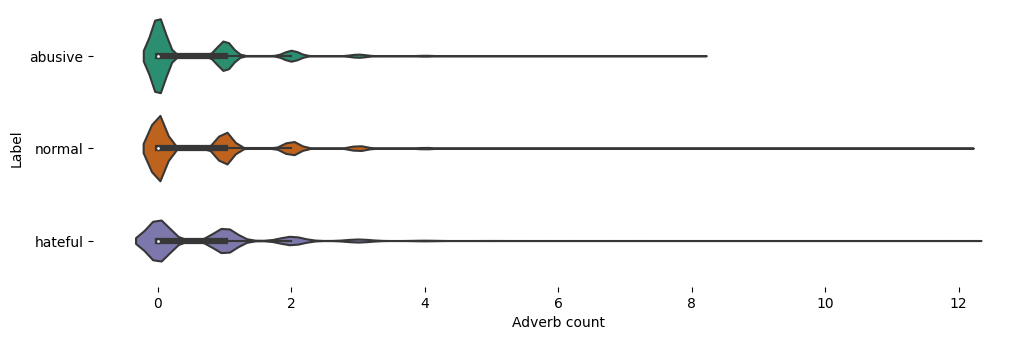

In [ ]:
figsize = (12, 1.2 * len(tweets['Label'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(tweets, x='Adverb count', y='Label', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

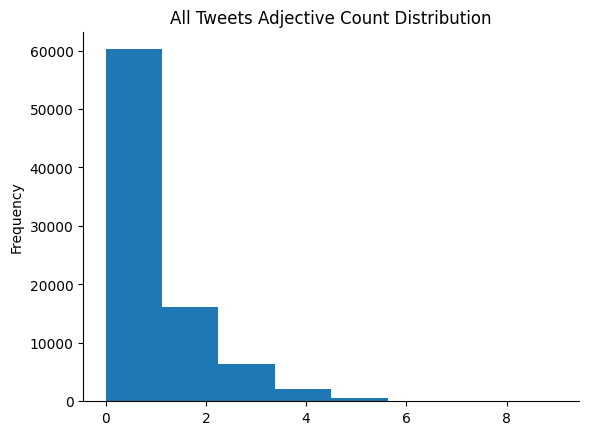

In [ ]:
tweets['Adjective count'].plot(kind='hist', bins=8, title='All Tweets Adjective Count Distribution')
plt.gca().spines[['top', 'right',]].set_visible(False)

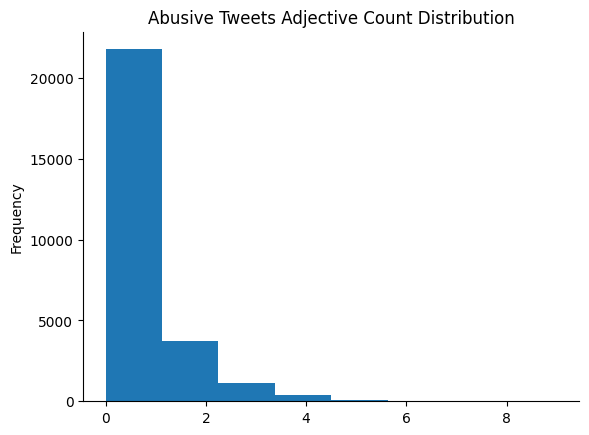

In [ ]:
tweets[tweets['Label'] == "abusive"]['Adjective count'].plot(kind='hist', bins=8, title='Abusive Tweets Adjective Count Distribution')
plt.gca().spines[['top', 'right',]].set_visible(False)

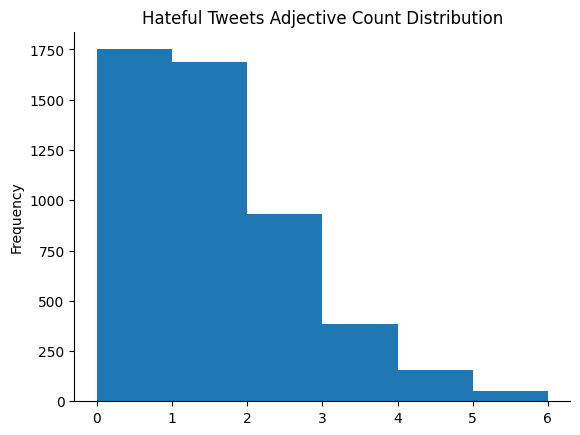

In [ ]:
tweets[tweets['Label'] == "hateful"]['Adjective count'].plot(kind='hist', bins=6, title='Hateful Tweets Adjective Count Distribution')
plt.gca().spines[['top', 'right',]].set_visible(False)

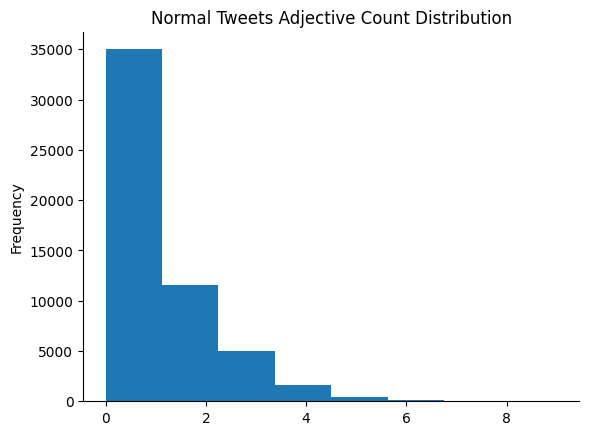

In [ ]:
tweets[tweets['Label'] == "normal"]['Adjective count'].plot(kind='hist', bins=8, title='Normal Tweets Adjective Count Distribution')
plt.gca().spines[['top', 'right',]].set_visible(False)

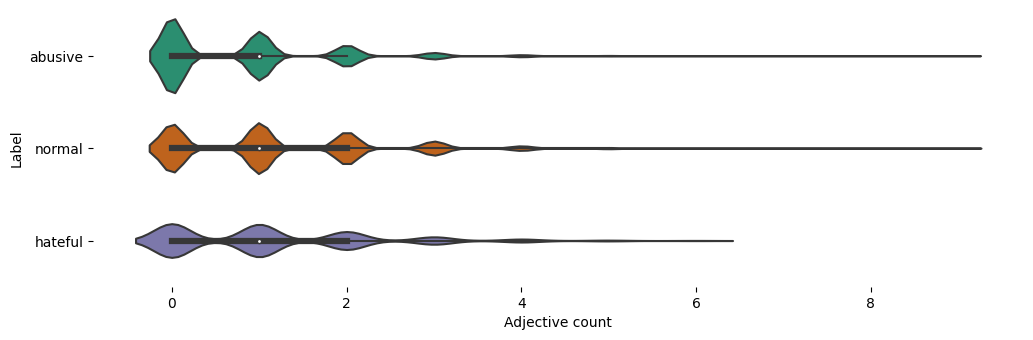

In [ ]:
figsize = (12, 1.2 * len(tweets['Label'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(tweets, x='Adjective count', y='Label', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

Aggressive Tweets

In [ ]:
#combine abusive and hateful tweets into aggressive for later comparison with other work
aggressive_tweets = tweets_copy
aggressive_tweets = aggressive_tweets.replace("abusive","aggressive")
aggressive_tweets = aggressive_tweets.replace("hateful","aggressive")
aggressive_tweets

,Tweet text,Label,@ count,Hashtag count,Retweet,Url count,Uppercase word count,Num sentences,Avg sentence len,Sentiment,Adjective count,Verb count,Adverb count,Profanity count,Avg word len
1,Man it would fucking rule if we had a party ...,aggressive,1,0,True,0,0,1,16.0,0.1280,1,3,0,1,4.266667
2,It is time to draw close to Him Father I draw...,normal,0,2,False,1,1,1,20.0,0.0000,0,4,3,0,3.294118
3,if you notice me start to act different or dis...,normal,0,0,False,0,0,1,35.0,0.0000,5,8,0,0,3.633333
4,Forget unfollowers I believe in growing new f...,normal,0,0,False,1,1,3,6.0,-0.1260,3,1,0,0,4.714286
5,Hate Being sexually Frustrated Like I wanna ...,aggressive,1,0,True,0,1,1,16.0,-0.8689,0,2,1,3,4.785714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99991,my fucking queen,aggressive,1,0,True,1,0,1,3.0,0.0000,0,0,0,1,4.666667
99992,treated with rebuild bone mass,normal,0,3,False,2,0,1,7.0,0.0000,0,1,0,0,5.200000
99993,why does my phone screen keeps flickring im s...,normal,1,4,False,0,0,1,29.0,-0.9430,4,4,2,1,3.576923
99994,vs but equally applies to any project,normal,0,3,False,2,0,1,8.0,0.0000,0,0,1,0,4.428571


In [ ]:
#check to make sure only aggressive and normal tweet labels exist
pd.unique(aggressive_tweets['Label'])

array(['aggressive', 'normal'], dtype=object)

Agg Tweet Analysis

In [ ]:
aggressive_tweets['Label'].value_counts()

normal        53655
aggressive    32104
Name: Label, dtype: int64

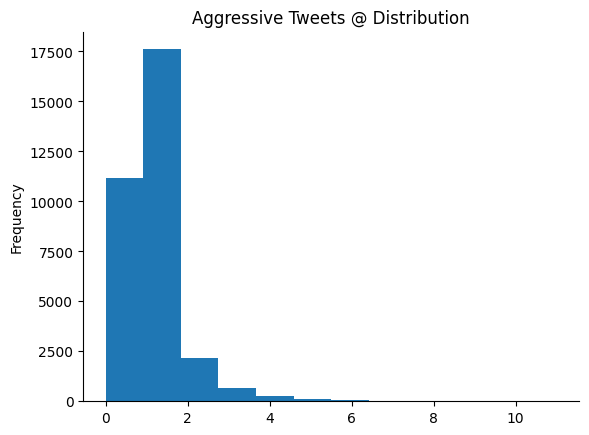

In [ ]:
aggressive_tweets[aggressive_tweets['Label'] == "aggressive"]['@ count'].plot(kind='hist', bins=12, title='Aggressive Tweets @ Distribution')
plt.gca().spines[['top', 'right',]].set_visible(False)

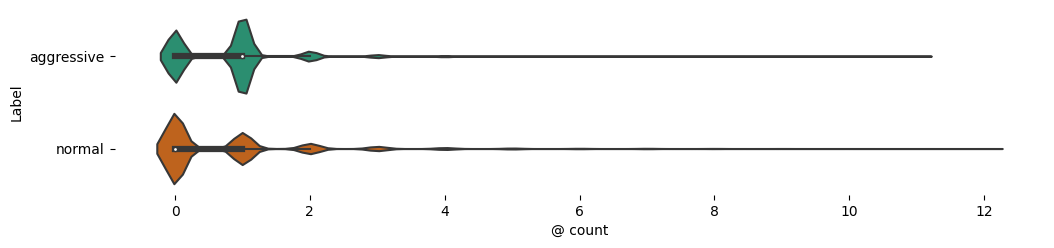

In [ ]:
figsize = (12, 1.2 * len(aggressive_tweets['Label'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(aggressive_tweets, x='@ count', y='Label', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

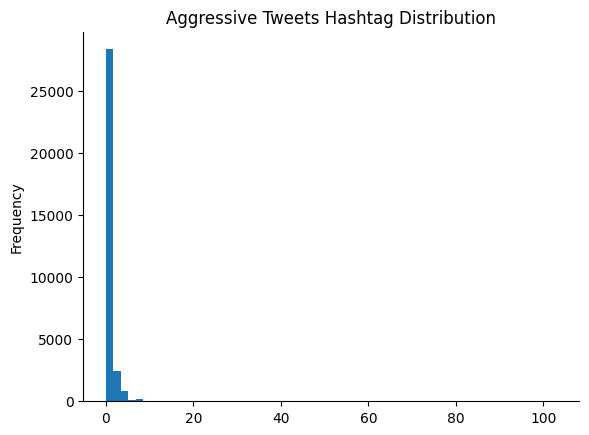

In [ ]:
aggressive_tweets[aggressive_tweets['Label'] == "aggressive"]['Hashtag count'].plot(kind='hist', bins=60, title='Aggressive Tweets Hashtag Distribution')
plt.gca().spines[['top', 'right',]].set_visible(False)

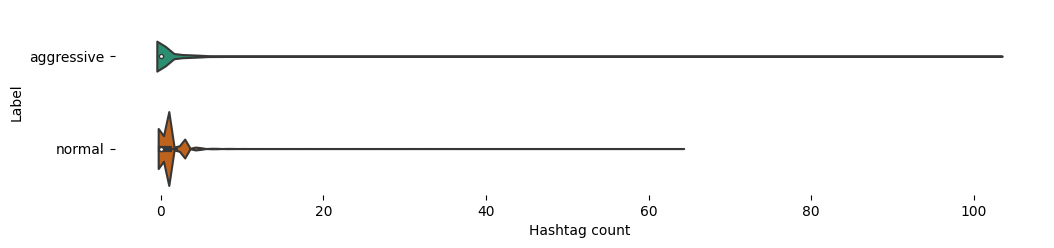

In [ ]:
figsize = (12, 1.2 * len(aggressive_tweets['Label'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(aggressive_tweets, x='Hashtag count', y='Label', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:
#Aggressive Tweets Retweet Distribution
aggressive_tweets[aggressive_tweets['Label'] == "aggressive"]['Retweet'].value_counts()

False    16723
True     15381
Name: Retweet, dtype: int64

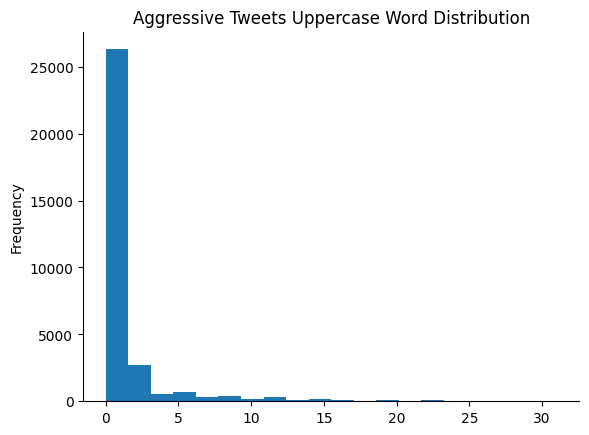

In [ ]:
aggressive_tweets[aggressive_tweets['Label'] == "aggressive"]['Uppercase word count'].plot(kind='hist', bins=20, title='Aggressive Tweets Uppercase Word Distribution')
plt.gca().spines[['top', 'right',]].set_visible(False)

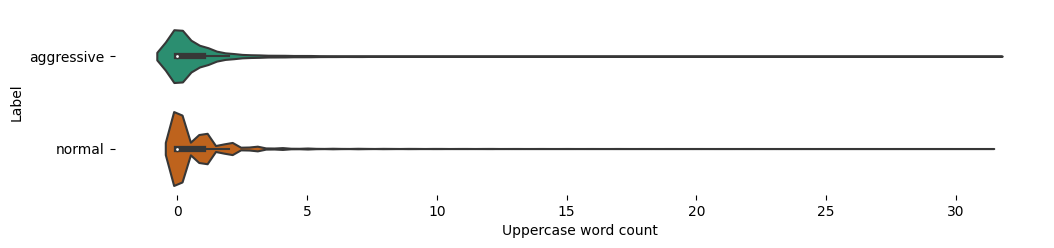

In [ ]:
figsize = (12, 1.2 * len(aggressive_tweets['Label'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(aggressive_tweets, x='Uppercase word count', y='Label', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

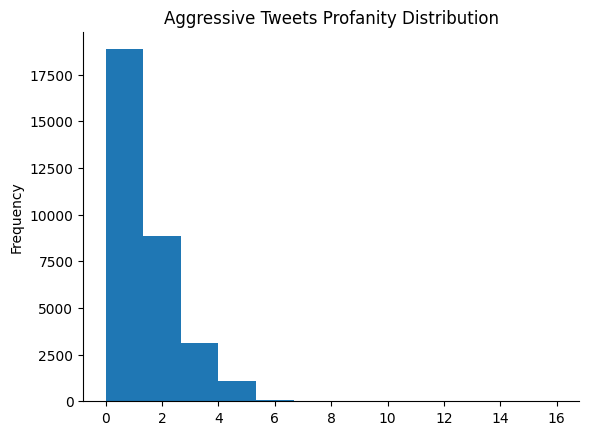

In [ ]:
aggressive_tweets[aggressive_tweets['Label'] == "aggressive"]['Profanity count'].plot(kind='hist', bins=12, title='Aggressive Tweets Profanity Distribution')
plt.gca().spines[['top', 'right',]].set_visible(False)

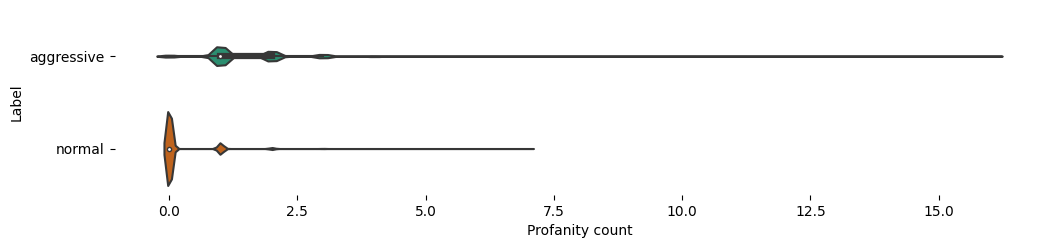

In [ ]:
figsize = (12, 1.2 * len(aggressive_tweets['Label'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(aggressive_tweets, x='Profanity count', y='Label', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

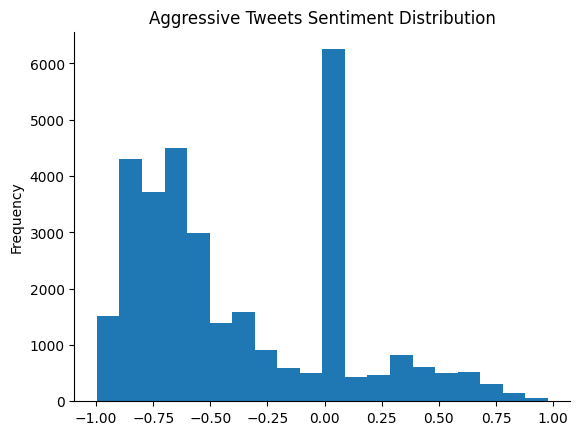

In [ ]:
aggressive_tweets[aggressive_tweets['Label'] == "aggressive"]['Sentiment'].plot(kind='hist', bins=20, title='Aggressive Tweets Sentiment Distribution')
plt.gca().spines[['top', 'right',]].set_visible(False)

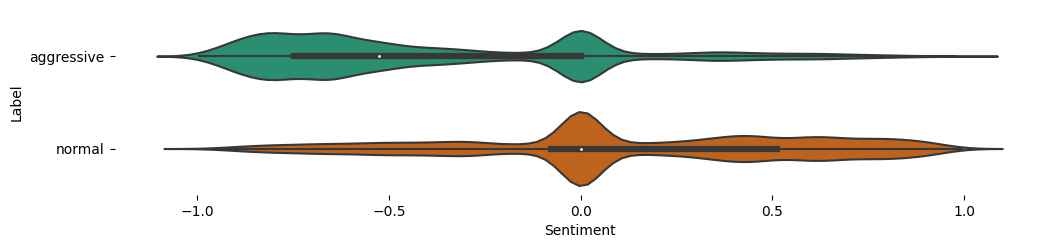

In [ ]:
figsize = (12, 1.2 * len(aggressive_tweets['Label'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(aggressive_tweets, x='Sentiment', y='Label', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

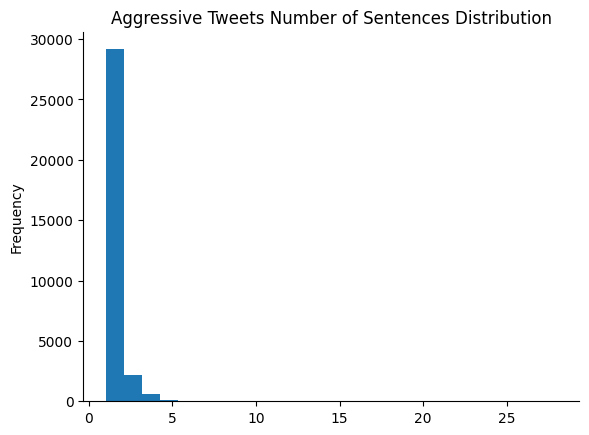

In [ ]:
aggressive_tweets[aggressive_tweets['Label'] == "aggressive"]['Num sentences'].plot(kind='hist', bins=25, title='Aggressive Tweets Number of Sentences Distribution')
plt.gca().spines[['top', 'right',]].set_visible(False)

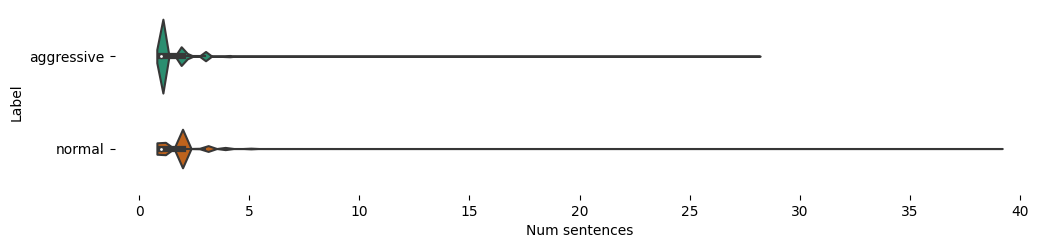

In [ ]:
figsize = (12, 1.2 * len(aggressive_tweets['Label'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(aggressive_tweets, x='Num sentences', y='Label', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

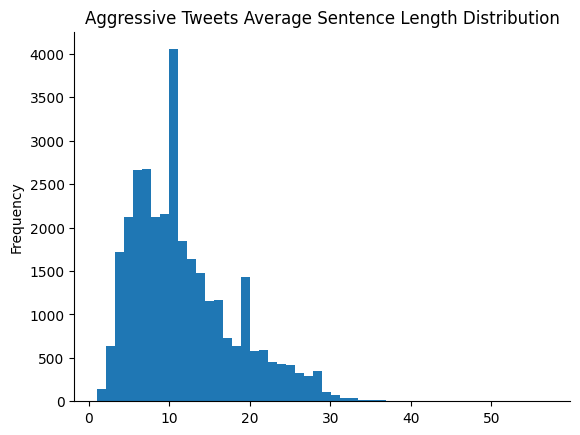

In [ ]:
aggressive_tweets[aggressive_tweets['Label'] == "aggressive"]['Avg sentence len'].plot(kind='hist', bins=50, title='Aggressive Tweets Average Sentence Length Distribution')
plt.gca().spines[['top', 'right',]].set_visible(False)

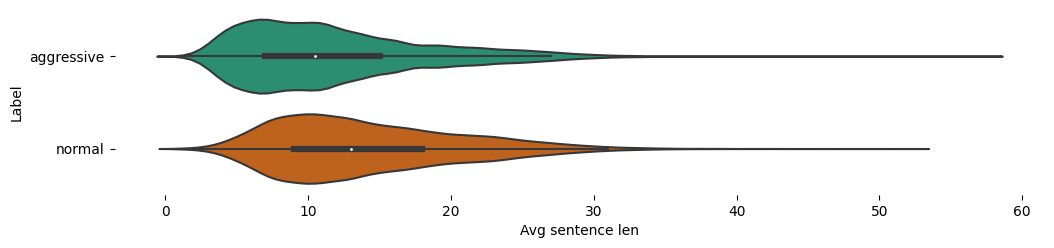

In [ ]:
figsize = (12, 1.2 * len(aggressive_tweets['Label'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(aggressive_tweets, x='Avg sentence len', y='Label', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

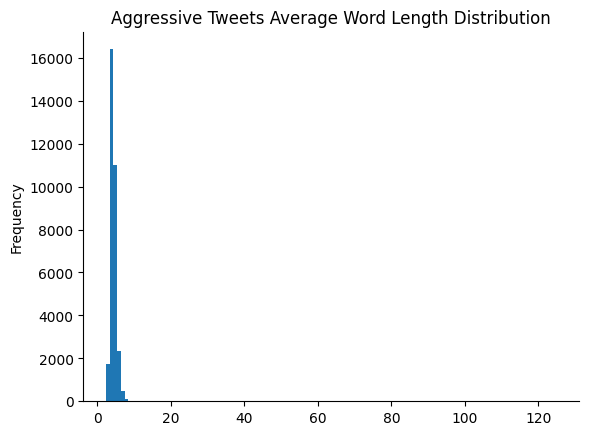

In [ ]:
aggressive_tweets[aggressive_tweets['Label'] == "aggressive"]['Avg word len'].plot(kind='hist', bins=120, title='Aggressive Tweets Average Word Length Distribution')
plt.gca().spines[['top', 'right',]].set_visible(False)

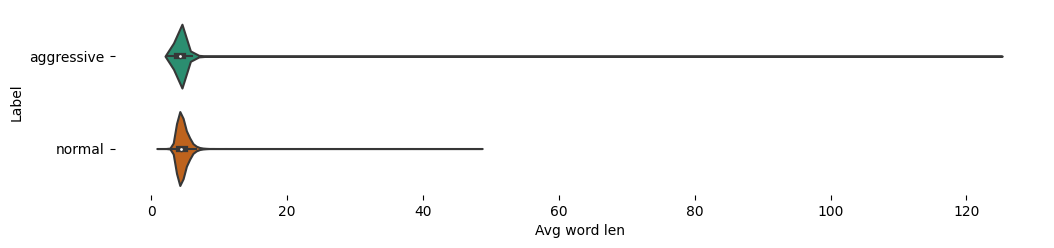

In [ ]:
figsize = (12, 1.2 * len(aggressive_tweets['Label'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(aggressive_tweets, x='Avg word len', y='Label', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

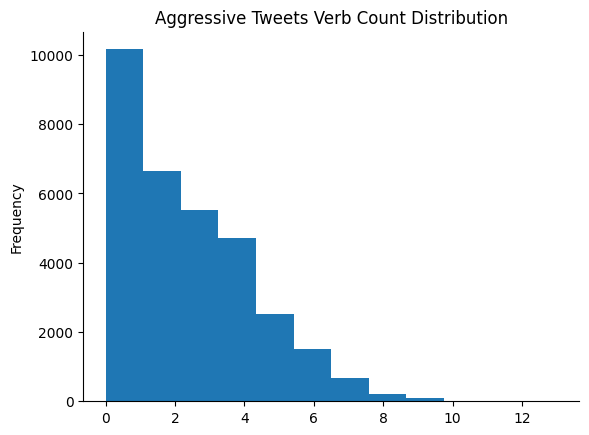

In [ ]:
aggressive_tweets[aggressive_tweets['Label'] == "aggressive"]['Verb count'].plot(kind='hist', bins=12, title='Aggressive Tweets Verb Count Distribution')
plt.gca().spines[['top', 'right',]].set_visible(False)

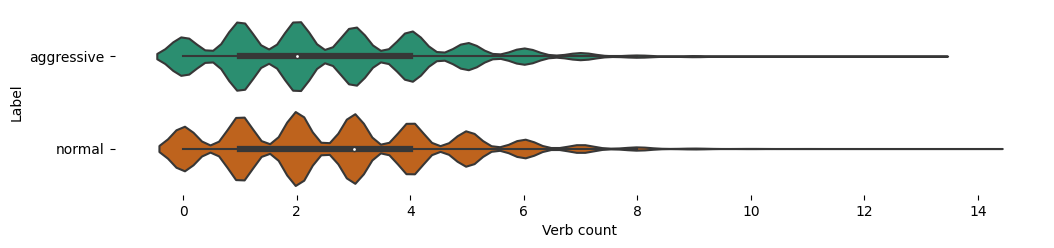

In [ ]:
figsize = (12, 1.2 * len(aggressive_tweets['Label'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(aggressive_tweets, x='Verb count', y='Label', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

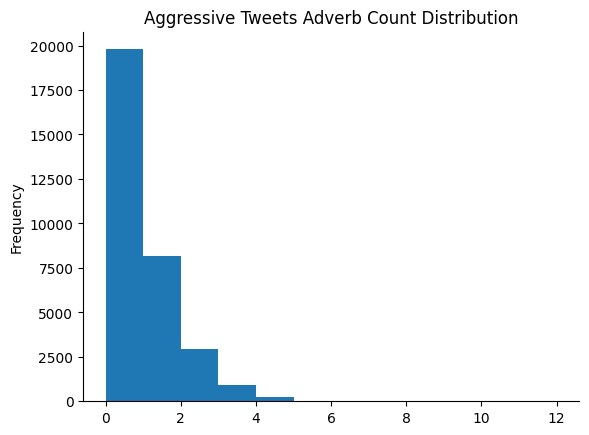

In [ ]:
aggressive_tweets[aggressive_tweets['Label'] == "aggressive"]['Adverb count'].plot(kind='hist', bins=12, title='Aggressive Tweets Adverb Count Distribution')
plt.gca().spines[['top', 'right',]].set_visible(False)

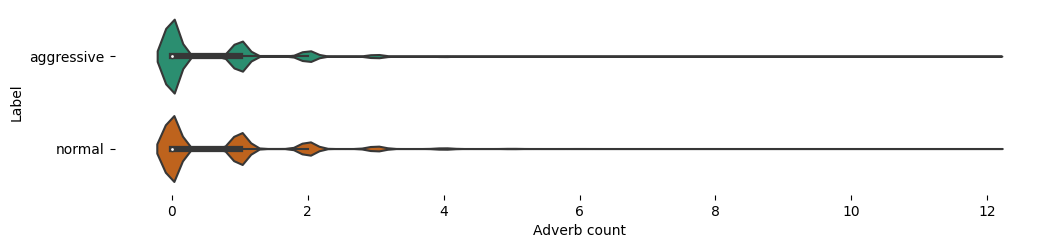

In [ ]:
figsize = (12, 1.2 * len(aggressive_tweets['Label'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(aggressive_tweets, x='Adverb count', y='Label', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

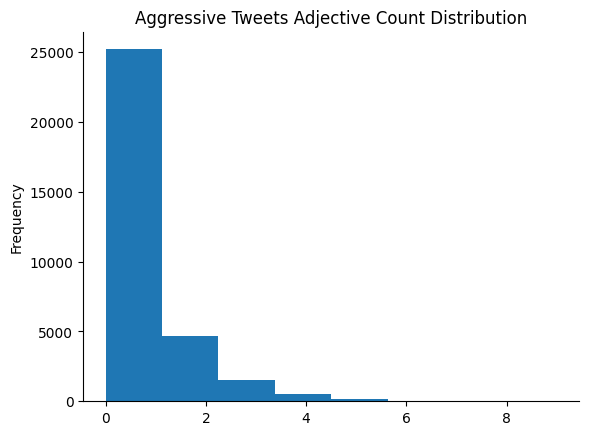

In [ ]:
aggressive_tweets[aggressive_tweets['Label'] == "aggressive"]['Adjective count'].plot(kind='hist', bins=8, title='Aggressive Tweets Adjective Count Distribution')
plt.gca().spines[['top', 'right',]].set_visible(False)

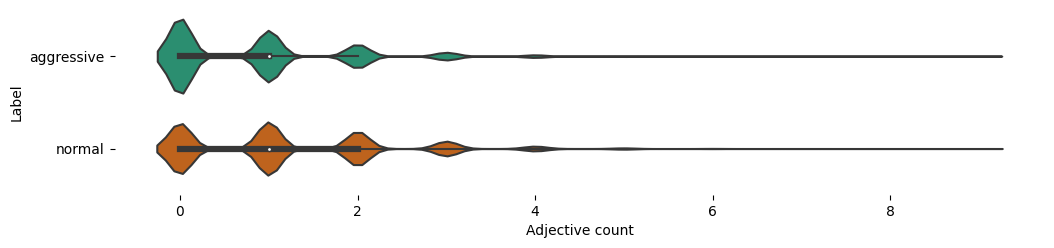

In [ ]:
figsize = (12, 1.2 * len(aggressive_tweets['Label'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(aggressive_tweets, x='Adjective count', y='Label', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)